# Selec window size on permutation entropy

In [39]:
import glob
import itertools
import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('MMPE'))
import mmpe
import statistics
import matplotlib.pyplot as plt
from tqdm import notebook
import pickle
import tsfel
import seaborn as sns

In [40]:
%load_ext autoreload
%autoreload 2

%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
dirpath = '/home/jarvis/Documentos/catalina/hmm/TIME_SERIES/'
subjects = [os.path.basename(x) for x in glob.glob(dirpath + '*sub*')]
scans = ['_scan_restpre', '_scan_restpost']
stimuli = ['ses-occ','ses-ctr', 'ses-fro' ]

parcel="_mask_Schaefer2018_400_17N_MNI152_2mm_mask_file_..input..data..Schaefer2018_400_17N_MNI152_2mm.nii.gz"
np.random.seed(42)

In [42]:
schafer_file = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_Centroid_RAS.csv'
schafer = pd.read_csv(schafer_file, header=None, skiprows=[0,1])
schafer['network'] = schafer[1].str.split('_').str.get(2)
schafer['network_id'] = schafer.network.astype("category").cat.codes
schafer_image = '/home/jarvis/Documentos/catalina/hmm/tms_hmm/Schaefer2018_400_17N_MNI152_2mm.nii'

In [43]:
def get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer):    

    subject_list = []
    all_data = []
    for subject in subjects:
        file_path = f'{dirpath}/{subject}/{stimulus}/roi_timeseries_0/{scan}/_compcor_ncomponents_5_selector_pc10.linear1.wm1.global0.motion1.quadratic1.gm0.compcor1.csf1/_bandpass_freqs_0.01.0.1/{parcel}/roi_stats.csv'
        series = pd.read_csv(file_path, skiprows=[0,1], header=None, delimiter='\t')
        series = series.T
        series['network'] = schafer['network']
        series_nolimbic = series[series.network!='Limbic']
        del series_nolimbic["network"]
        df_series = series_nolimbic.T
        all_data.append(df_series.values)
        subject_list.append(subject)
  
    return all_data, subject_list
    

def get_all_data(scans, stimuli,subjects, dirpath, parcel,schafer): 
    all_c = []
    all_subjects = []

    for scan in scans:

        for stimulus in stimuli:
  
            all_data, subject_list = get_time_series(dirpath, subjects, stimulus, scan, parcel,schafer)
            all_subjects = all_subjects +  subject_list
            all_c = all_c + all_data
          
    return all_c, all_subjects

## OCC

In [44]:
occ_pre, subjects_list_occ_pre = get_all_data(['_scan_restpre'], ['ses-occ'], subjects, dirpath, parcel,schafer)
occ_post, subjects_list_occ_post =  get_all_data(['_scan_restpost'], ['ses-occ'], subjects, dirpath, parcel,schafer)

all_occ = occ_pre + occ_post
subjects_occ = subjects_list_occ_pre + subjects_list_occ_post
y_occ = [0]*len(subjects_list_occ_pre) + [1]*len(subjects_list_occ_post)

cat_subjects = pd.get_dummies(subjects_occ)

subjects_id_occ = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

X_occ = np.swapaxes(np.swapaxes(np.dstack(all_occ), 0,2),1,2)
y_occ = np.array(y_occ)

X_occ.shape

(46, 600, 376)

## Calculate windows size

In [45]:
all_occ_concatenated = np.concatenate(all_occ)
a = tsfel.signal_window_splitter(all_occ_concatenated, 32, overlap=0.8)
a[0].T.shape

(376, 32)

In [46]:
range_l = range(8,180,8)

In [47]:
ws_st_0 = []
overlap = 0
for w in notebook.tqdm(range_l):
    ws_subjects = []
    ws_subjects_st = []
    for subject_serie in X_occ:
        windows_signal = tsfel.signal_window_splitter(subject_serie, w, overlap=overlap)
        
        pe_w = []
        for window in notebook.tqdm(windows_signal):
            segment = window.T
            pe_channel, pe_cross, norm_pe_cross = mmpe.mpe(segment,3,1)
            pe_w.append(norm_pe_cross)
            
        ws_subjects_st.append(statistics.stdev(pe_w))
        ws_subjects.append(np.array(pe_w))
    ws_st_0.append(np.array(ws_subjects_st))
        
        
    

/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: divide by zero encountered in log2
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: invalid value encountered in multiply
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))


/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: divide by zero encountered in log2
  pe_cross = -np.nansum(rp * np.log2(rp))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: invalid value encountered in multiply
  pe_cross = -np.nansum(rp * np.log2(rp))


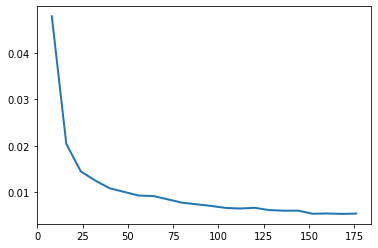

In [48]:
fig, ax = plt.subplots()

ax.plot(list(range_l), np.mean( ws_st_0, axis=1) , linewidth=2.0)


plt.show()

In [49]:
array_0= np.array(ws_st_0)
pa_ws_st_0 = pd.DataFrame(array)
pa_ws_st_0["window_size"] = list(range_l)
pa_ws_st_0_melt = pd.melt(pa_ws_st_0, id_vars='window_size', var_name='subject', value_name = 'sd_pe')

Text(0, 0.5, 'SD PE')

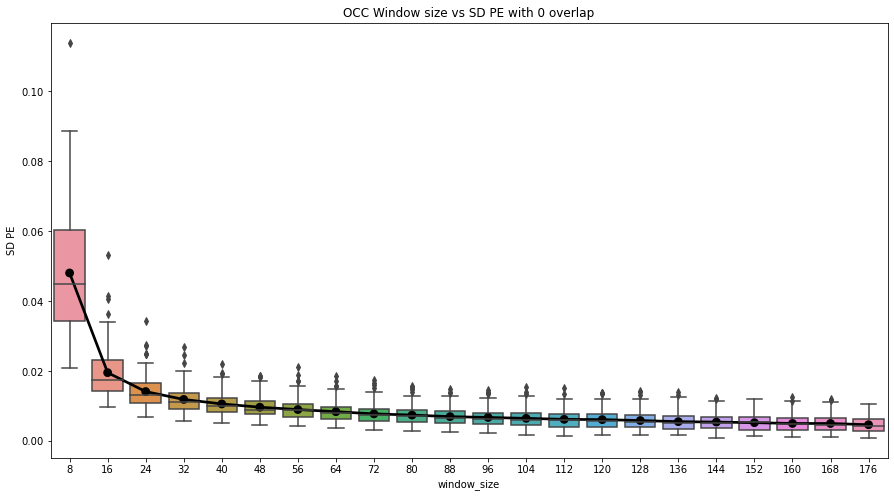

In [50]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x="window_size", y="sd_pe",
            data=pa_ws_st_0_melt).set(title='OCC Window size vs SD PE with 0 overlap')
sns.pointplot(x='window_size', y='sd_pe', data=pa_ws_st_melt, ci=None, color='black')
plt.ylabel('SD PE')

In [52]:
with open('ws_sd0.pkl', 'wb') as f:
    pickle.dump(ws_st_0, f)

## With 0.5 overlap

In [53]:
ws_st05 = []
overlap = 0.5
for w in notebook.tqdm(range_l):
    ws_subjects = []
    ws_subjects_st = []
    for subject_serie in X_occ:
        windows_signal = tsfel.signal_window_splitter(subject_serie, w, overlap=overlap)
        
        pe_w = []
        for window in windows_signal:
            segment = window.T
            pe_channel, pe_cross, norm_pe_cross = mmpe.mpe(segment,3,1)
            pe_w.append(norm_pe_cross)
            
        ws_subjects_st.append(statistics.stdev(pe_w))
        ws_subjects.append(np.array(pe_w))
    ws_st05.append(np.array(ws_subjects_st))
        

/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: divide by zero encountered in log2
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: invalid value encountered in multiply
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: divide by zero encountered in log2
  pe_cross = -np.nansum(rp * np.log2(rp))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: invalid value encountered in multiply
  pe_cross = -np.nansum(rp * np.log2(rp))


In [54]:
array05= np.array(ws_st05)
pa_ws_st05 = pd.DataFrame(array05)
pa_ws_st05["window_size"] = list(range_l)
pa_ws_st05_melt = pd.melt(pa_ws_st05, id_vars='window_size', var_name='subject', value_name = 'pe')

Text(0, 0.5, 'SD PE')

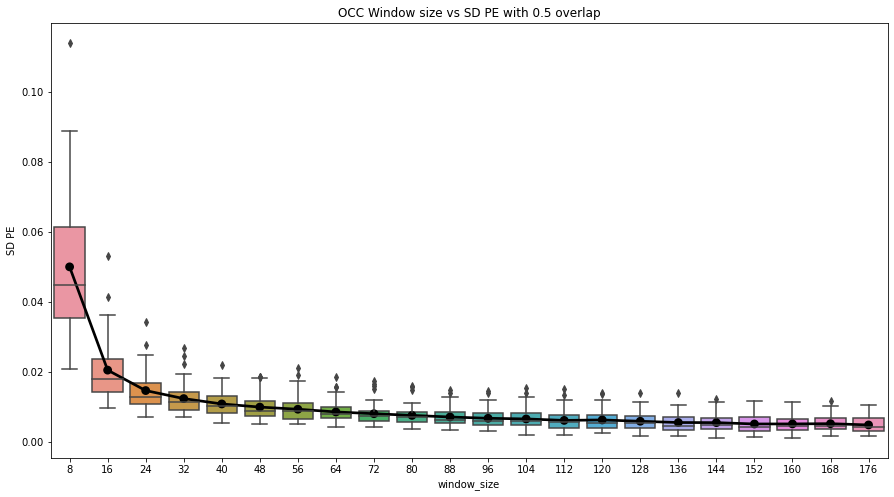

In [55]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x="window_size", y="pe",
            data=pa_ws_st05_melt).set(title='OCC Window size vs SD PE with 0.5 overlap')
sns.pointplot(x='window_size', y='pe', data=pa_ws_st05_melt, ci=None, color='black')
plt.ylabel('SD PE')

In [57]:
with open('ws_sd05.pkl', 'wb') as f:
    pickle.dump(ws_st05, f)

## with 0.9 overlap

In [59]:
ws_st09 = []
overlap = 0.9
for w in notebook.tqdm(range_l):
    ws_subjects = []
    ws_subjects_st = []
    for subject_serie in X_occ:
        windows_signal = tsfel.signal_window_splitter(subject_serie, w, overlap=overlap)
        
        pe_w = []
        for window in windows_signal:
            segment = window.T
            pe_channel, pe_cross, norm_pe_cross = mmpe.mpe(segment,3,1)
            pe_w.append(norm_pe_cross)
            
        ws_subjects_st.append(statistics.stdev(pe_w))
        ws_subjects.append(np.array(pe_w))
    ws_st09.append(np.array(ws_subjects_st))

In [60]:
array09= np.array(ws_st09)
pa_ws_st09 = pd.DataFrame(array09)
pa_ws_st09["window_size"] = list(range_l)
pa_ws_st09_melt = pd.melt(pa_ws_st09, id_vars='window_size', var_name='subject', value_name = 'pe')

Text(0, 0.5, 'SD PE')

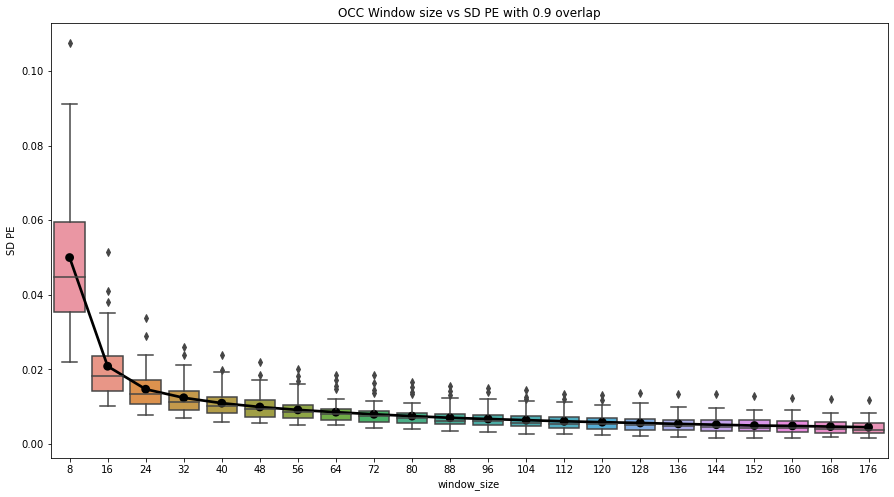

In [61]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x="window_size", y="pe",
            data=pa_ws_st09_melt).set(title='OCC Window size vs SD PE with 0.9 overlap')
sns.pointplot(x='window_size', y='pe', data=pa_ws_st09_melt, ci=None, color='black')
plt.ylabel('SD PE')

In [62]:
with open('ws_sd_9.pkl', 'wb') as f:
    pickle.dump(ws_st09, f)

## All pre and post

In [63]:
all_pre, subjects_list_all_pre = get_all_data(['_scan_restpre'], ['ses-occ','ses-ctr','ses-fro'], subjects, dirpath, parcel,schafer)
all_post, subjects_list_all_post =  get_all_data(['_scan_restpost'], ['ses-occ','ses-ctr','ses-fro'], subjects, dirpath, parcel,schafer)

all_s = all_pre + all_post
subjects_all = subjects_list_all_pre + subjects_list_all_post
y_all = [0]*len(subjects_list_all_pre) + [1]*len(subjects_list_all_post)

cat_subjects = pd.get_dummies(subjects_all)

subjects_id_all = cat_subjects.values.argmax(1)

class_names = ['Pre', 'Post']

X_all = np.swapaxes(np.swapaxes(np.dstack(all_s), 0,2),1,2)
y_all = np.array(y_all)

X_all.shape

(138, 600, 376)

In [64]:
ws_st_all = []
overlap = 0.5
for w in notebook.tqdm(range_l):
    ws_subjects = []
    ws_subjects_st = []
    for subject_serie in X_all:
        windows_signal = tsfel.signal_window_splitter(subject_serie, w, overlap=overlap)
        
        pe_w = []
        for window in windows_signal:
            segment = window.T
            pe_channel, pe_cross, norm_pe_cross = mmpe.mpe(segment,3,1)
            pe_w.append(norm_pe_cross)
            
        ws_subjects_st.append(statistics.stdev(pe_w))
        ws_subjects.append(np.array(pe_w))
    ws_st_all.append(np.array(ws_subjects_st))

/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: divide by zero encountered in log2
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:48: RuntimeWarning: invalid value encountered in multiply
  pe_channel.append(-np.nansum(p[f] * np.log2(p[f])))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: divide by zero encountered in log2
  pe_cross = -np.nansum(rp * np.log2(rp))
/home/jarvis/Documentos/catalina/hmm/MMPE/mmpe.py:56: RuntimeWarning: invalid value encountered in multiply
  pe_cross = -np.nansum(rp * np.log2(rp))


In [65]:
array_all= np.array(ws_st_all)
pa_ws_st_all = pd.DataFrame(array_all)
pa_ws_st_all["window_size"] = list(range_l)
pa_ws_st_melt_all = pd.melt(pa_ws_st_all, id_vars='window_size', var_name='subject', value_name = 'pe')

Text(0, 0.5, 'SD PE')

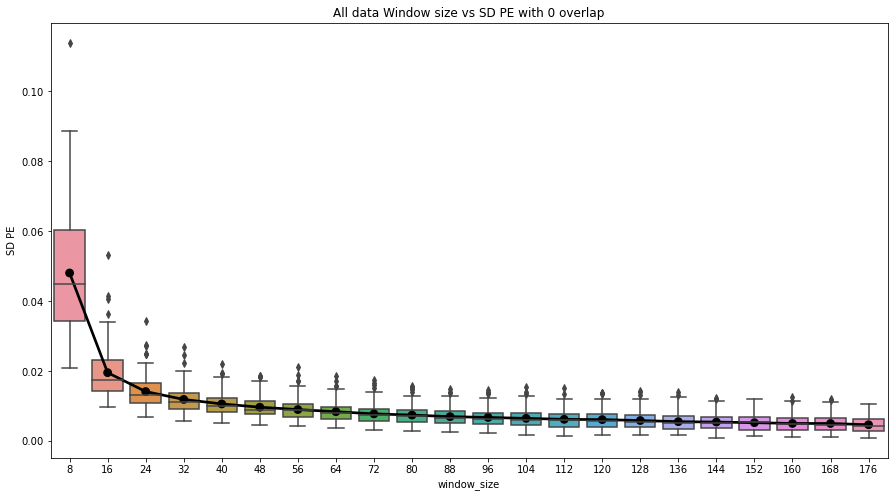

In [66]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(x="window_size", y="pe",
            data=pa_ws_st_melt_all).set(title='All data Window size vs SD PE with 0 overlap')
sns.pointplot(x='window_size', y='pe', data=pa_ws_st_melt_all, ci=None, color='black')
plt.ylabel('SD PE')